# Neural Systems 2021: Automated vocal segmentation project

Student names: Armin Meier, Karin Zimmermann, Noah Lüthi, Julian Büchel, Lukas Fluri

Group: 4c

## PART C: Find the best solution
Now you are free to be creative and get the best solution for automated vocal segmentation in zebra finch songbirds.
Some interesting neural network architectures are: cbow (linear layer + softmax function), wave-net-like (convolutional), bert, vae


### Available training datasets:
* g17y2: 90% of all spectrograms, 90% of all 
annotations
* g19o10: 90% of all spectrograms, 10% of all annotations
* g4p5: 90% of all spectrograms, 0.3% of all annotations
* R3428: 90% of all spectrograms, 90% of all annotations (juvenile bird)

Notes: 
* When only a fraction of the spectrograms are annotated, the indices of these annotated spectrograms are stored in annotations_train.SETindex_labelled.
* Be careful that R3428 has different spectrogram parameters (e.g. annotations_train.scanrate=44100)

### Constraints, filtering, and final tests performed by TA:
**Window sizes** everyone should visit in their screening (used in final tests): 28ms, 64ms, 104ms

**Recommended gap sizes** to visit: 0, 12ms, 28ms

**Tests** will be run for each bird, for each variant and each of the above window sizes on the 10% of held-out test data for that bird.

**An example of filtering binary labels and definition of segmentation test** performed by TAs can be found here:
[Syllable score (by Xinyu Hao)](https://drive.google.com/file/d/10Vzqu2Z1x1jFSsKwwjOBd-8jhfe9-Q_c/view?usp=sharing)


*Task*: Please introduce and motivate your decisions here: TODO




## Segmentation (offline & online variants)
*Task*: 
For each bird, for offline and online variants of the task, and for each of the above window sizes, please train a network that will predict segmentation on the 10% test set of that bird.
Please store the optimal hyperparameters (including optimal gap size), optimizer choices, loss functions, and trained network parameters (using [pytorch-checkpoint](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training), or a well-documented equivalent method).

**NOTE:** You first need to run all the cells at the very end of this notebook which contain the definition of the functions _task1()_ - _taskx()_

In [1]:
#task1()

*Task*:
Can you improve segmentation by extending the pipeline with a filter to remove noise in binary labelling across a given time window?
If so, please document your approach and store any parameters that you use.

*Task*:
For birds g17y2 and R3428 separately, how much labelled data is needed to have good performance for an entire data set? Characterize the tradeoff between amount of annotation data and improvement in precision and recall of the binary label predictor.




In [2]:
#task3()

*Task* (optional):
Generalization across birds: How well does a segmentation network trained on a subset of the birds perform on a left-out (out-of-distribution) bird?


In [3]:
#task4()

## Clustering (optional)
To go beyond a binary classifier, you would need to find out how many vocalization / noise / silence types there are (clustering). Once you know the number of these classes, one could adjust the number of output neurons.  Some interesting approaches to define classes are: coreset, matching pursuit, kmeans.

Another approach - which we have used in the past - is to extend the pipeline with more processing steps by extracting vocal segments (that can be obtained from grouping binary labels of your segmentation network) and clustering them based on their acoustic features.


### Discussion
*Task*: Discuss your findings.

# Function implementations
## Global config variables

In [1]:
run_tasks = {
    "task1": True,
    "task3": True,
    "task4": True
}

# Choose between "Local" and "Euler"
execution_mode = "Local"

## Imports

In [9]:
if execution_mode == "Local":
    %load_ext autoreload
    %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import gc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as path
from joblib import dump, load
from pickle import dumps
from hashlib import sha256

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

from utils import (
    # Constants
    DEVICE, BIRD_NAMES, DATA_PATH, MODEL_PATH, PREDICTIONS_PATH,

    # Data handling functions
    load_bird_data, extract_labelled_spectograms, train_test_split,
    extract_birds, create_windows, store_birds, load_birds, store_dataset,
    load_dataset, flatten_windows_dic, standardize_data,

    # Other stuff
    hash_spectograms, tuples2vector, score_predictions
)

from classifiers import (
    # For the cnn
    train_CNN, predict_syllables_CNN, load_cnn, wrap_cnn,

    # For the rnn
    train_RNN, predict_syllables_RNN, load_rnn, wrap_rnn,

    # For transfer learning
    get_transfer_learning_models_CNN, get_transfer_learning_models_RNN
)

from analyze_errors import compare_classifiers

## Small helper functions

In [11]:
def hash_object(obj, ndigits = 6):
    return sha256(dumps(obj)).hexdigest()[-ndigits:]

## Task 1

In [24]:
def task1(plot=True):
    """
    For each bird, for offline and online variants of the task, and for each of the above window sizes, 
    please train a network that will predict segmentation on the 10% test set of that bird. Please store 
    the optimal hyperparameters (including optimal gap size), optimizer choices, loss functions, and 
    trained network parameters (using pytorch-checkpoint, or a well-documented equivalent method).
    """
    ## Set a few parameters
    # This corresponds to 28ms, 64ms, 104ms
    wnd_sizes = [7,16,26]
    bird_names = ["g17y2", "g19o10", "g4p5", "R3428"]
    online_mode = [False, True]
    
    # Some data parameters
    test_frac = 0.1       # Fraction of spectograms in the test_set
    if execution_mode == "Local":
        limit = 100           # Amount of windows to extract for training, validation and test set
        dt = 50
    else:
        limit = 80000
        dt = 3
    on_fracs=0.5          # Fraction of windows which should have 'vocal' target
                   # Stride
    
    # Some RNN parameters
    network_type = "gru"  # Choose from {'rnn', 'lstm', 'gru'}
    num_layers = 1        # Number of layers of the rnn. 1 should be ok.
    hidden_size = 100     # Size of the hidden input of the rnn
    
    # A dictionary where all the MSEs of the different neural networks will be stored
    results = {}
    
    # Check if the results of these experiments have already been computed
    parameter_hash = hash_object([wnd_sizes, bird_names, online_mode, test_frac, limit, on_fracs, dt, network_type, num_layers, hidden_size])
    result_path = PREDICTIONS_PATH + f"task1_results_hash_{parameter_hash}"
    
    if path.isfile(result_path):
        results = load(result_path)
    else:
        # Train the models for all specified birds, window sizes and online modes
        # First iterate over all birds
        for bird_name in bird_names:
            # Run garbage collection to free unused memory
            gc.collect()
            print("Working on bird: ", bird_name)

            # The bird "g4p5" only contains one labelled spectogram so we can't really train a classifier for this
            # TODO: Change implementation so that it's possible!
            if bird_name == "g4p5":
                continue

            results[bird_name] = {}

            # First load the data of the current bird
            bird_data = load_bird_data(names = bird_name)

            # Extract the labelled data
            bird_data, _ = extract_labelled_spectograms(bird_data)

            # Split the spectograms of this bird into a train-, validation-, and test set
            train_data, test_data = train_test_split({bird_name : bird_data[bird_name]}, configs = test_frac, seed = 42)
            train_data, validation_data = train_test_split(train_data, configs = 0.2, seed = 42)

            # After the bird data is ready, iterate over all window sizes and online modes
            for wnd_size in wnd_sizes:
                results[bird_name][wnd_size] = {}
                for online in online_mode:
                    results[bird_name][wnd_size]["online" if online else "offline"] = {}

                    # Run garbage collection to free unused memory
                    gc.collect()                

                    # Extract windows for the training, validation and test set
                    data = [train_data, validation_data, test_data]
                    windows = []
                    for dataset in data:
                        windows.append(create_windows(
                            bird_data=dataset,
                            wnd_sizes=wnd_size,
                            limits=limit,
                            on_fracs=on_fracs,
                            dt=dt,
                            online = online,
                            seed=42)[0])

                    windows_train, windows_validation, windows_test = windows

                    # Transform the dictionary into an array, which can be used to train our models
                    X_train, y_train = flatten_windows_dic(windows_train[wnd_size])
                    X_validation, y_validation = flatten_windows_dic(windows_validation[wnd_size])
                    X_test, y_test = flatten_windows_dic(windows_test[wnd_size])

                    # Prepare the final dataset
                    dataset = {
                        "train": (X_train, y_train),
                        "validation": (X_validation, y_validation),
                        "test": (X_test, y_test)
                    }

                    # Train a CNN and an RNN
                    cnn_name = f"task1_cnn_{bird_name}_wnd_{wnd_size}_online_{online}_size_{len(X_train)}"
                    rnn_name = f"task1_rnn_{bird_name}_wnd_{wnd_size}_online_{online}_size_{len(X_train)}"

                    print("Start training for ", cnn_name)
                    cnn = train_CNN(dataset,model_name = cnn_name, normalize_input=False, online=online)

                    print("Start training for ", rnn_name)
                    rnn = train_RNN(dataset,model_name=rnn_name, network_type=network_type, hidden_size=hidden_size, 
                                    num_layers=num_layers, normalize_input=False, online=online)

                    # Make predictions for the test set
                    y_pred_cnn = cnn(X_test)
                    y_pred_rnn = rnn(X_test).cpu()

                    def metrics(y_true, y_pred):
                        # Compute error metrics
                        precision, recall, f1, _ = precision_recall_fscore_support(
                            y_true,
                            y_pred,
                            average="binary"
                        )
                        accuracy = accuracy_score(y_true, y_pred)
                        return {"accuracy": accuracy, 
                                "precision": precision, 
                                "recall": recall, 
                                "f1":f1}

                    results[bird_name][wnd_size]["online" if online else "offline"]["cnn"] = metrics(y_test, y_pred_cnn)
                    results[bird_name][wnd_size]["online" if online else "offline"]["rnn"] = metrics(y_test, y_pred_rnn)
        
        # Store the result to avoid recomputing everything the next time
        dump(results, result_path)
    
    if not plot:
        return
    
    # Plot the results
    # TODO put bird "g4p5" back in!
    for bird_name in bird_names:
        if bird_name == "g4p5":
            continue
        
        for online in online_mode:
            for model in ["rnn","cnn"]:
                for index, mode in enumerate(["online", "offline"]):
                    scores = []
                    accuracies = []
                    precisions = []
                    recalls = []
                    
                    for wnd_size in wnd_sizes:
                        accuracies.append(results[bird_name][wnd_size][mode][model]["accuracy"])
                        precisions.append(results[bird_name][wnd_size][mode][model]["precision"])
                        recalls.append(results[bird_name][wnd_size][mode][model]["recall"])
                    
                    plt.figure(figsize=(9,6))
                    plt.plot(wnd_sizes, accuracies, label = "Accuracy", marker='x')
                    plt.plot(wnd_sizes, precisions, label = "Precision", marker='x')
                    plt.plot(wnd_sizes, recalls, label = "Recall", marker='x')
                    plt.grid(which="both")
                    plt.title(f"Metrics of {model} on bird {bird_name} using {mode} mode")
                    plt.xlabel("Window size")
                    plt.ylabel("Metrics")
                    plt.legend()

if run_tasks["task1"]:
    make_plots = True if execution_mode == "Local" else False
    task1(plot = make_plots)

Working on bird:  g17y2
Start training for  task1_cnn_g17y2_wnd_7_online_False_size_122
Epoch 0 Loss 0.8205429911613464
Validation accuracy is 0.6746031641960144
Epoch 1 Loss 0.6274225115776062
Validation accuracy is 0.8650793433189392
Epoch 2 Loss 0.4890042841434479
Validation accuracy is 0.8571428656578064
Epoch 3 Loss 0.4058479070663452
Validation accuracy is 0.8571428656578064
Epoch 4 Loss 0.3383786380290985
Validation accuracy is 0.8492063283920288
Epoch 5 Loss 0.281819611787796
Validation accuracy is 0.8571428656578064
Epoch 6 Loss 0.26283010840415955
Validation accuracy is 0.8888888955116272
Epoch 7 Loss 0.2870013117790222
Validation accuracy is 0.9365079402923584
Epoch 8 Loss 0.22948025166988373
Validation accuracy is 0.9365079402923584
Epoch 9 Loss 0.24628612399101257
Validation accuracy is 0.9285714030265808
Test acc. 0.9568345546722412
Start training for  task1_rnn_g17y2_wnd_7_online_False_size_122
Test acc. 0.8992805480957031
Start training for  task1_cnn_g17y2_wnd_7_online

KeyboardInterrupt: 

## Task 3

In [28]:
def task3(plot = True):
    """
    For birds g17y2 and R3428 separately, how much labelled data is needed to have good performance for 
    an entire data set? Characterize the tradeoff between amount of annotation data and improvement in 
    precision and recall of the binary label predictor.
    """
    ## Set a few parameters
    bird_names = ["g17y2", "R3428"]
    wnd_size = 20
    
    # Some data parameters
    test_frac = 0.2             # Fraction of spectograms in the test_set
    if execution_mode == "Local":
        limits = [100,200,300,500]  # Amount of windows to extract for training- and validation set combined 
        dt = 50
    else:
        limits = [100,1000,10000,100000]
        dt = 3
    on_fracs=0.5                # Fraction of windows which should have 'vocal' target
    dt = 50                     # Stride
    
    # Some RNN parameters
    network_type = "gru"  # Choose from {'rnn', 'lstm', 'gru'}
    num_layers = 1        # Number of layers of the rnn. 1 should be ok.
    hidden_size = 100     # Size of the hidden input of the rnn
    
    # A dictionary where all the MSEs of the different neural networks will be stored
    results = {}
    
    # Check if the results of these experiments have already been computed
    parameter_hash = hash_object([bird_names, wnd_size, test_frac, limits, on_fracs, dt, network_type, num_layers, hidden_size])
    result_path = PREDICTIONS_PATH + f"task3_results_hash_{parameter_hash}"
    
    if path.isfile(result_path):
        results = load(result_path)
    else:
        # Train the models for all specified birds, window sizes and online modes
        # First iterate over all birds
        for bird_name in bird_names:
            print("Working on bird: ", bird_name)

            results[bird_name] = {}

            # First load the data of the current bird
            bird_data = load_bird_data(names = bird_name)

            # Extract the labelled data
            bird_data, _ = extract_labelled_spectograms(bird_data)

            # Split the spectograms of this bird into a train-, validation-, and test set
            train_data, test_data = train_test_split({bird_name : bird_data[bird_name]}, configs = test_frac, seed = 42)
            train_data, validation_data = train_test_split(train_data, configs = 0.2, seed = 42)

            for limit in limits:
                results[bird_name][limit] = {"cnn":{}, "rnn":{}}

                # Run garbage collection to free unused memory
                gc.collect()

                data = [(train_data, int(limit * 0.9)), (validation_data,limit - int(limit * 0.9)), (test_data,limit)]

                windows = []
                for data_tuple in data:
                    dataset, amount_of_windows = data_tuple
                    windows.append(create_windows(
                        bird_data=dataset,
                        wnd_sizes=wnd_size,
                        limits=amount_of_windows,
                        on_fracs=on_fracs,
                        dt=dt,
                        online = False,
                        seed=42)[0])

                windows_train, windows_validation, windows_test = windows

                # Transform the dictionary into an array, which can be used to train our models
                X_train, y_train = flatten_windows_dic(windows_train[wnd_size])
                X_validation, y_validation = flatten_windows_dic(windows_validation[wnd_size])
                X_test, y_test = flatten_windows_dic(windows_test[wnd_size])

                # Prepare the final dataset
                dataset = {
                    "train": (X_train, y_train),
                    "validation": (X_validation, y_validation),
                    "test": (X_test, y_test)
                }

                # Train a CNN and an RNN
                cnn_name = f"task3_cnn_{bird_name}_wnd_{wnd_size}_size_{len(X_train)}"
                rnn_name = f"task3_rnn_{bird_name}_wnd_{wnd_size}_size_{len(X_train)}"

                print("Start training for ", cnn_name)
                cnn = train_CNN(dataset,model_name = cnn_name, normalize_input=False)
                cnn = wrap_cnn(cnn, mode="for_spectograms", normalize_input=False)

                print("Start training for ", rnn_name)
                rnn = train_RNN(dataset,model_name=rnn_name, network_type=network_type, hidden_size=hidden_size, num_layers=num_layers, normalize_input=False)
                rnn = wrap_rnn(rnn, mode="for_spectograms", normalize_input=False)

                # Make predictions for the test set
                summary_cnn = compare_classifiers(dataset=bird_data, model_dic={f"cnn_bird_{bird_name}_windows_{limit}": cnn}, print_summary=False)
                summary_rnn = compare_classifiers(dataset=bird_data, model_dic={f"rnn_bird_{bird_name}_windows_{limit}": rnn}, print_summary=False)

                results[bird_name][limit]["cnn"] = {
                    "score": np.mean(summary_cnn[bird_name][f"cnn_bird_{bird_name}_windows_{limit}"]["score_mean"]),
                    "accuracy": summary_cnn[bird_name][f"cnn_bird_{bird_name}_windows_{limit}"]["accuracy"],
                    "precision": summary_cnn[bird_name][f"cnn_bird_{bird_name}_windows_{limit}"]["precision"],
                    "recall": summary_cnn[bird_name][f"cnn_bird_{bird_name}_windows_{limit}"]["recall"]
                }
                results[bird_name][limit]["rnn"] = {
                    "score": np.mean(summary_rnn[bird_name][f"rnn_bird_{bird_name}_windows_{limit}"]["score_mean"]),
                    "accuracy": summary_rnn[bird_name][f"rnn_bird_{bird_name}_windows_{limit}"]["accuracy"],
                    "precision": summary_rnn[bird_name][f"rnn_bird_{bird_name}_windows_{limit}"]["precision"],
                    "recall": summary_rnn[bird_name][f"rnn_bird_{bird_name}_windows_{limit}"]["recall"]
                }
        
        # Store the result to avoid recomputing everything the next time
        dump(results, result_path)
    
    if not plot:
        return
    
    # Plot the results
    # TODO: Fix CNN. when done, uncomment line 107
    for bird_name in bird_names:
        for model in ["rnn","cnn"]:
            scores = []
            accuracies = []
            precisions = []
            recalls = []
            for limit in limits:
                scores.append(results[bird_name][limit][model]["score"])
                accuracies.append(results[bird_name][limit][model]["accuracy"])
                precisions.append(results[bird_name][limit][model]["precision"])
                recalls.append(results[bird_name][limit][model]["recall"])
                
            plt.figure(figsize=(9,6))
            plt.plot(limits, scores, label = "Score", marker='x')
            plt.plot(limits, accuracies, label = "Accuracy", marker='x')
            plt.plot(limits, precisions, label = "Precision", marker='x')
            plt.plot(limits, recalls, label = "Recall", marker='x')
            plt.grid(which="both")
            plt.title(f"Metrics of {model} on bird {bird_name}")
            plt.xlabel("Training set size")
            plt.ylabel("Metrics")
            plt.legend()

if run_tasks["task3"]:
    make_plots = True if execution_mode == "Local" else False
    task3(plot = make_plots)

Working on bird:  g17y2
Start training for  task3_cnn_g17y2_wnd_20_size_100
Test acc. 0.9076923131942749
Start training for  task3_rnn_g17y2_wnd_20_size_100
Test acc. 0.8538461327552795
Make predictions for bird g17y2 using the model cnn_bird_g17y2_windows_100
You need to see what happens
Make predictions for bird g17y2 using the model rnn_bird_g17y2_windows_100
Start training for  task3_cnn_g17y2_wnd_20_size_203
Test acc. 0.8901960849761963
Start training for  task3_rnn_g17y2_wnd_20_size_203
Test acc. 0.8470588326454163
Make predictions for bird g17y2 using the model cnn_bird_g17y2_windows_200
Make predictions for bird g17y2 using the model rnn_bird_g17y2_windows_200
You need to see what happens
Start training for  task3_cnn_g17y2_wnd_20_size_280
Test acc. 0.9178470373153687
Start training for  task3_rnn_g17y2_wnd_20_size_280
Test acc. 0.9376770257949829
Make predictions for bird g17y2 using the model cnn_bird_g17y2_windows_300
You need to see what happens
Make predictions for bird g1

KeyboardInterrupt: 

## Task 4

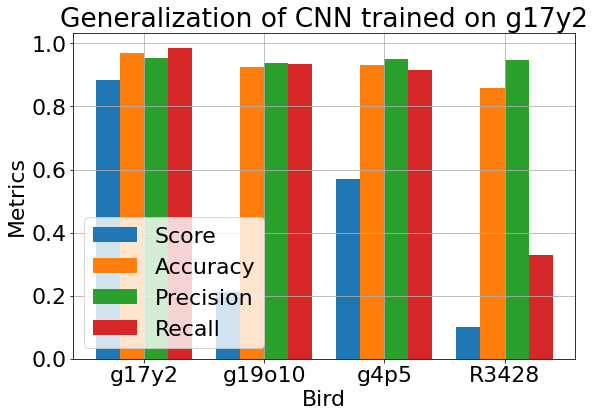

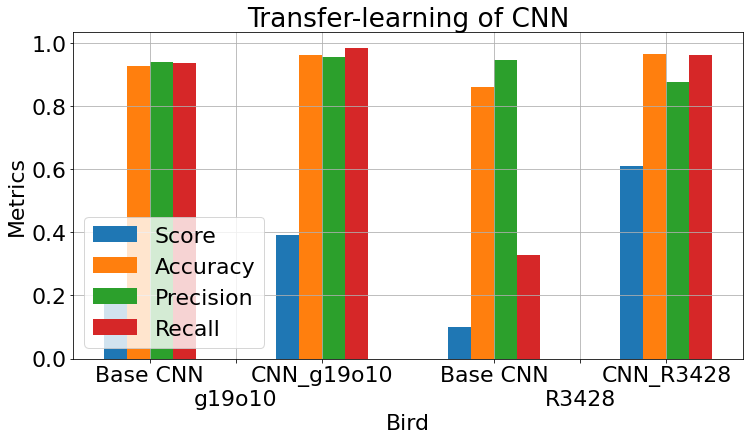

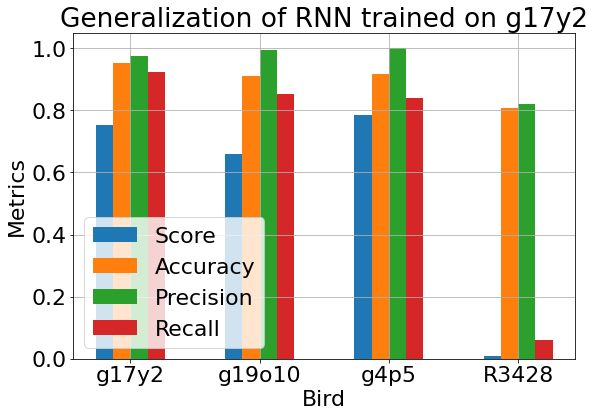

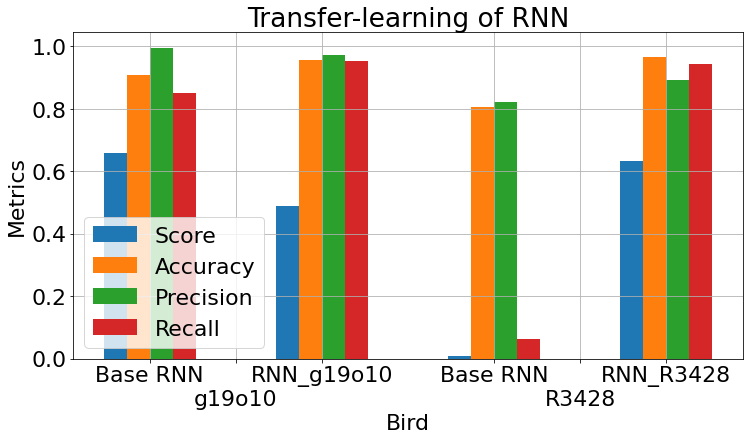

In [10]:
def task4(plot = True):
    """
    Generalization across birds: How well does a segmentation network trained on a subset of the birds 
    perform on a left-out (out-of-distribution) bird?
    """
    # Set some general parameters
    use_feature_extraction = False
    wnd_sz = 20
    if execution_mode == "Local":
        limit = 100#70000
    else:
        limit = 80000
    standardize = False
    online = False

    # Some RNN parameters
    network_type = "gru"    # Choose from {'rnn', 'lstm', 'gru'}
    num_layers = 1
    hidden_size = 100

    # The paths to the models
    #base = path.dirname(path.abspath(__file__))
    base = os.getcwd()
    cnn_name = "task4_cnn_features_%s_wnd_sz_%s_limit_%s.model" % (use_feature_extraction, wnd_sz, limit)
    cnn_path = path.join(base, MODEL_PATH+cnn_name)
    rnn_name = "task4_rnn_type_%s_num_layers_%s_hidden_size_%s_features_%s_wnd_sz_%s_limit_%s.model" % (
        network_type, num_layers, hidden_size, use_feature_extraction, wnd_sz, limit)
    rnn_path = path.join(base, MODEL_PATH+rnn_name)
    
    # Check if the results of these experiments have already been computed
    parameter_hash = hash_object([use_feature_extraction, wnd_sz, limit, standardize, online, network_type, num_layers, hidden_size])
    result_path = PREDICTIONS_PATH + f"task4_results_hash_{parameter_hash}"
    
    if path.isfile(result_path):
        (summary_cnn, summary_rnn) = load(result_path)
    else:

        if not (path.isfile(cnn_path) and path.isfile(rnn_path)):
            # Load the data and get all labelled spectograms
            bird_data = load_bird_data(names=["g17y2"])

            if standardize:
                bird_data = standardize_data(bird_data, coarse_mode="per_spectogram", fine_mode="scalar")
            data_labelled, _ = extract_labelled_spectograms(bird_data)

            # Perform a train-validation-test split
            data_train, data_test = train_test_split(bird_data=data_labelled, configs=0.33, seed=42)
            data_val, data_test = train_test_split(bird_data=data_test, configs=0.5, seed=42)

            # Extract the windows from the spectograms
            windows_train, _ = create_windows(bird_data=data_train, wnd_sizes=wnd_sz, limits=limit, on_fracs=0.5, dt=5, seed=42)
            windows_val, _ = create_windows(bird_data=data_val, wnd_sizes=wnd_sz, limits=int(limit/2), on_fracs=0.5, dt=5, seed=42)
            windows_test, _ = create_windows(bird_data=data_test, wnd_sizes=wnd_sz, limits=int(limit/2), on_fracs=0.5, dt=5, seed=42)

            X_train, y_train = flatten_windows_dic(windows_train[wnd_sz])
            X_val, y_val = flatten_windows_dic(windows_val[wnd_sz])
            X_test, y_test = flatten_windows_dic(windows_test[wnd_sz])

            dataset = {
                "train": (X_train, y_train),
                "validation": (X_val, y_val),
                "test": (X_test, y_test)
            }

            if not path.isfile(cnn_path):
                cnn = train_CNN(dataset, cnn_name, normalize_input=True, online=online)
            if not path.isfile(rnn_path):
                rnn = train_RNN(dataset, rnn_name, network_type=network_type, hidden_size=hidden_size,
                                num_layers=num_layers, normalize_input=True, online=online)

        # Load the CNN
        cnn = load_cnn(cnn_path, wnd_sz, online=online)
        rnn = load_rnn(rnn_path, network_type, nfreq=128, hidden_size=hidden_size, num_layers=num_layers, device=DEVICE)

        # Print the number of parameters
        print("CNN has ", sum(p.numel() for p in cnn.parameters()), " parameters.")
        print("RNN has ", sum(p.numel() for p in rnn.parameters()), " parameters.")

        cnn_wrapped = wrap_cnn(cnn, mode="for_spectograms")
        rnn_wrapped = wrap_rnn(rnn, mode="for_spectograms")
        #compare_classifiers(dataset=None, model_dic={"cnn": cnn_wrapped, "rnn": rnn_wrapped}, print_summary=True)

        gc.collect()

        transfer_model_dic_cnn = get_transfer_learning_models_CNN(
            bird_names=["g19o10", "R3428"],
            base_model=cnn,
            arch="task4_cnn_",
            wnd_sz=wnd_sz,
            limit=limit,
            retrain_layers=4,
            standardize_input=standardize)

        gc.collect()

        transfer_model_dic_rnn = get_transfer_learning_models_RNN(
            bird_names=["g19o10", "R3428"],
            base_model=rnn,
            arch="task4_rnn_",
            wnd_sz=wnd_sz,
            limit=limit,
            network_type=network_type,  # Choose from ["rnn","lstm","gru"]
            hidden_size=hidden_size,
            num_layers=num_layers,
            retrain_layers=4,
            nfreq=128,
            standardize_input=standardize
        )

        gc.collect()

        transfer_model_dic_cnn["base_CNN"] = cnn
        transfer_model_dic_rnn["base_RNN"] = rnn

        for key in transfer_model_dic_cnn:
            transfer_model_dic_cnn[key] = wrap_cnn(transfer_model_dic_cnn[key], mode="for_spectograms", normalize_input=True)

        for key in transfer_model_dic_rnn:
            transfer_model_dic_rnn[key] = wrap_rnn(transfer_model_dic_rnn[key], mode="for_spectograms", normalize_input=True)

        summary_cnn = compare_classifiers(dataset=None, model_dic=transfer_model_dic_cnn, print_summary=True)
        summary_rnn = compare_classifiers(dataset=None, model_dic=transfer_model_dic_rnn, print_summary=True)
    
        # Store the result to avoid recomputing everything the next time
        dump((summary_cnn, summary_rnn), result_path)
        
    if not plot:
        return
    
    ################################################################################
    # Plotting starts here
    ################################################################################
    # Some plot parameters
    width = 0.2
    metric_names = ["Score","Accuracy", "Precision", "Recall"]
    x = np.arange(len(BIRD_NAMES)) # Amount of different bars to plot

    summaries = [summary_cnn, summary_rnn]
    for index, model in enumerate(["CNN", "RNN"]):
        ## First plot a summary of the base models over the different birds
        summary = summaries[index]
        scores = []
        accuracies = []
        precisions = []
        recalls = []

        # Extract the different metrics
        for bird_name in BIRD_NAMES:
            scores.append(summary[bird_name]['base_'+model]["score_mean"])
            accuracies.append(summary[bird_name]['base_'+model]["accuracy"])
            precisions.append(summary[bird_name]['base_'+model]["precision"])
            recalls.append(summary[bird_name]['base_'+model]["recall"])

        metrics = [scores, accuracies, precisions, recalls]

        # Make the first plots showing how the base models performed over all birds
        plt.figure(figsize=(9,6))
        for i in range(len(metrics)):
            plt.bar(x + i * width, metrics[i], width, label = metric_names[i])
        plt.grid(which="both")
        plt.title(f"Generalization of {model} trained on {BIRD_NAMES[0]}")
        plt.xticks(x + 1.5 * width, BIRD_NAMES)
        plt.xlabel("Bird")
        plt.ylabel("Metrics")
        plt.legend(loc='lower left')

        # Now generate the second type of plots showing how transfer learning improved the situation
        x = np.array([0,1.5,3,4.5])
        x2 = np.array([0,0.75,1.5,3,3.75,4.5])
        scores = []
        accuracies = []
        precisions = []
        recalls = []
        for bird_name in ["g19o10", "R3428"]:
            scores.append(summary[bird_name]['base_'+model]["score_mean"])
            scores.append(summary[bird_name]['task4_'+model.lower()+"_"+bird_name]["score_mean"])
            accuracies.append(summary[bird_name]['base_'+model]["accuracy"])
            accuracies.append(summary[bird_name]['task4_'+model.lower()+"_"+bird_name]["accuracy"])
            precisions.append(summary[bird_name]['base_'+model]["precision"])
            precisions.append(summary[bird_name]['task4_'+model.lower()+"_"+bird_name]["precision"])
            recalls.append(summary[bird_name]['base_'+model]["recall"])
            recalls.append(summary[bird_name]['task4_'+model.lower()+"_"+bird_name]["recall"])

        metrics = [scores, accuracies, precisions, recalls]

        # Make the first plots showing how the base models performed over all birds
        plt.figure(figsize=(12,6))
        for i in range(len(metrics)):
            plt.bar(x + i * width, metrics[i], width, label = metric_names[i])
        plt.grid(which="both")
        plt.title(f"Transfer-learning of {model}")
        plt.xticks(x2 + 1.5 * width,[f"Base {model}", "\ng19o10", f"{model}_g19o10", f"Base {model}", "\nR3428", f"{model}_R3428"])
        plt.xlabel("Bird")
        plt.ylabel("Metrics")
        plt.legend(loc='lower left')

if run_tasks["task4"]:
    make_plots = True if execution_mode == "Local" else False
    task4(plot = make_plots)